In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from matplotlib import pylab
import pandas as pd
from pandas import DataFrame
import os

In [2]:
np.random.seed(123)

In [2]:
# read data
current_dir = os.path.dirname('__file__')
chains = []

for filename in os.listdir(os.path.join(current_dir, 'Results')): 
    chain = pd.read_csv( os.path.join('results', filename), index_col = 0)
    chains.append(chain)
    
parameters = list(chains[0])

In [3]:
# discard half of the simulations
chains_warmup = [chain.tail(int(chain.shape[0]/2)) for chain in chains]

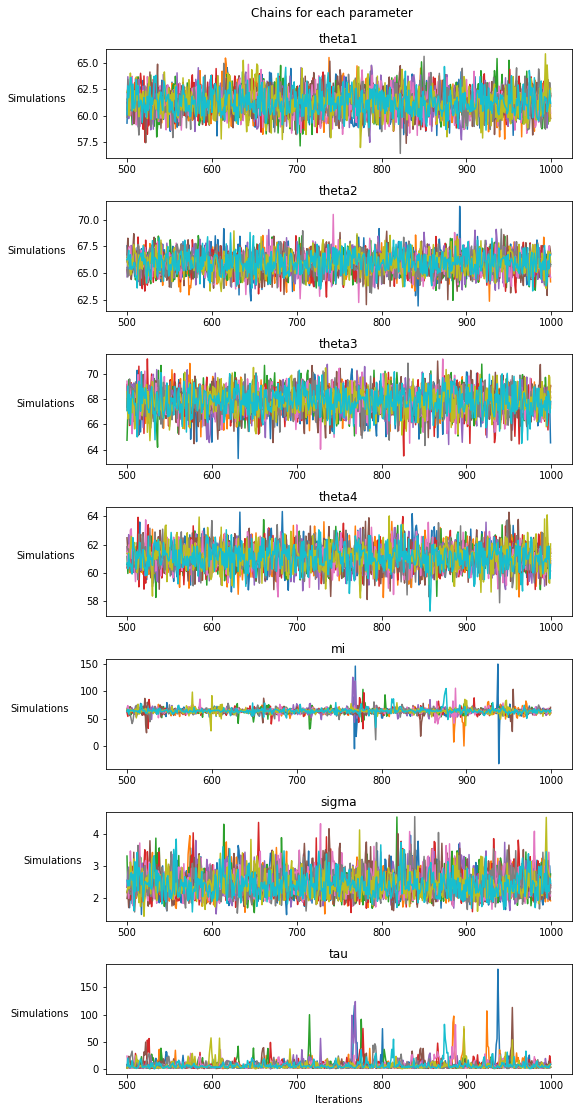

In [4]:
n_plots = len(parameters)
n_chains = len(chains_warmup)
cmap = plt.cm.tab10(np.linspace(0, 1, n_chains))

plt.figure(figsize=(8, 15))

for i in range(n_plots):
    
    n_sub = int(str(n_plots) + str(1) + str(i+1))
    plt.subplot(n_sub)
    plt.ylabel('Simulations', labelpad=40).set_rotation(0)
    plt.title(parameters[i])
    
    for chain, col in zip(chains_warmup, cmap):
        plt.plot(range(chain.shape[0],2*chain.shape[0]), chain[parameters[i]], color = col)

plt.xlabel('Iterations')
plt.tight_layout(pad=0.4, h_pad=1.0)
plt.suptitle('Chains for each parameter', y = 1.02, x = 0.57)
plt.show()


In [5]:
half_chains = [chain.head(int(chain.shape[0]/2)).reset_index(drop=True) for chain in chains_warmup]
half_chains += [chain.tail(int(chain.shape[0]/2)).reset_index(drop=True) for chain in chains_warmup]
m = len(half_chains)
n = half_chains[0].shape[0]
total_chain = pd.concat(half_chains).reset_index(drop=True)
total_mean = total_chain.mean()

In [6]:
variance_estimates = DataFrame(columns = ['B', 'W', 'varhat', 'Rhat'], index = parameters)

for par in parameters:
    
    Bvec = [chain[par].mean() - total_mean[par] for chain in half_chains]
    B = n/(m-1) * np.dot(Bvec,Bvec)
    
    Wvec = [ 1/(n-1) *np.dot(chain[par] - chain[par].mean(), chain[par] - chain[par].mean())
            for chain in half_chains ]
    W = np.mean(Wvec)
    
    varhat = (n-1)/n * W + 1/n * B
    
    Rhat = np.sqrt(varhat/W)
    
    variance_estimates.loc[par] = [B, W, varhat, Rhat]   

In [7]:
variance_estimates

,B,W,varhat,Rhat
theta1,1.0032,1.49917,1.49719,0.999338
theta2,1.21471,1.00384,1.00468,1.00042
theta3,2.07662,1.00455,1.00884,1.00213
theta4,0.912064,0.742049,0.742729,1.00046
mi,28.8446,32.1651,32.1518,0.999794
sigma,0.244715,0.164945,0.165265,1.00097
tau,203.01,72.0278,72.5517,1.00363


In [135]:
neff = DataFrame(columns = ['n','neff'], index = parameters)

for par in parameters:
    rhos = []
    for t in range(1,n):
        
        vecs = [chain[par].iloc[0:n-t].reset_index(drop=True) - \
            chain[par].iloc[t:n].reset_index(drop=True) for chain in half_chains]
        
        Vt = 1/(m*(n-t)) * sum([np.dot(vec,vec) for vec in vecs])
        rhot = 1 - Vt/(2*variance_estimates.loc[par,'varhat'])
        rhos.append(rhot)
        
        if t>0 and rhot + rhos[t-1] < 0:
            break
            
        neff.loc[par] = [m*n, m * n / (1 + 2* sum(rhos))]    

In [136]:
neff

,n,neff
theta1,5000,4044.37
theta2,5000,4689.25
theta3,5000,4195.72
theta4,5000,4590.27
mi,5000,3523.92
sigma,5000,3400.3
tau,5000,1193.47
